In [9]:
import numpy as np
import matplotlib.pyplot as plt
import squarify
import pandas as pd
import torch
import torch.nn as nn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, \
    f1_score

In [2]:
# Data loader class

class BreastCancerDataset():
    def load_data(self):
        """Loads raw data from the breast cancer dataset."""
        data = load_breast_cancer()
        X = data.data
        y = data.target
        return X, y

    def make_split(self, test_size=0.2, random_state=42):
        """Splits the data into training and testing sets."""
        X, y = self.load_data()
        X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=test_size, random_state=random_state)
        X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=random_state)

        # Normalize data after splitting to prevent data leakage
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)

        y_train = torch.tensor(y_train, dtype=torch.long)
        y_val = torch.tensor(y_val, dtype=torch.long)
        y_test = torch.tensor(y_test, dtype=torch.long)

        return X_train, X_test, X_val, y_train, y_test, y_val


In [5]:
# Neural network model class

class BreastCancerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BreastCancerModel, self).__init__()
        self.layer = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Output layer for binary classification

    def forward(self, x):
        out = self.layer(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out


In [6]:
# Training

data = BreastCancerDataset()
X_train, X_test, X_val, y_train, y_test, y_val = data.make_split()

input_features = X_train.shape[1]
hidden_neurons = 16

model = BreastCancerModel(input_size=input_features, hidden_size=hidden_neurons, num_classes=2)

criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

num_epochs = 100
train_losses = []
val_losses = []
accuracy_score_list = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

        _, predicted = torch.max(val_outputs.data, 1)
        accuracy = accuracy_score(y_val.cpu(), predicted.cpu())
        accuracy_score_list.append(accuracy)
    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy:.4f}')

Epoch [10/100], Loss: 0.2454, Val Loss: 0.1713, Val Accuracy: 0.9825
Epoch [20/100], Loss: 0.1035, Val Loss: 0.0445, Val Accuracy: 1.0000
Epoch [30/100], Loss: 0.0689, Val Loss: 0.0330, Val Accuracy: 1.0000
Epoch [40/100], Loss: 0.0566, Val Loss: 0.0334, Val Accuracy: 0.9825
Epoch [50/100], Loss: 0.0475, Val Loss: 0.0313, Val Accuracy: 0.9825
Epoch [60/100], Loss: 0.0416, Val Loss: 0.0353, Val Accuracy: 0.9825
Epoch [70/100], Loss: 0.0367, Val Loss: 0.0389, Val Accuracy: 0.9825
Epoch [80/100], Loss: 0.0326, Val Loss: 0.0420, Val Accuracy: 0.9825
Epoch [90/100], Loss: 0.0288, Val Loss: 0.0439, Val Accuracy: 0.9825
Epoch [100/100], Loss: 0.0252, Val Loss: 0.0449, Val Accuracy: 0.9825


In [7]:
# Evaluation on test set

model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    y_true = y_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    correct = (predicted == y_test).sum().item()
print(f'Test Accuracy: {accuracy:.4f}')
print('correctly classified samples:', correct, 'out of', len(y_test))
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

Test Accuracy: 0.9825
correctly classified samples: 56 out of 57
Precision: 0.9677
Recall: 1.0000
F1 Score: 0.9836
Confusion Matrix:
[[26  1]
 [ 0 30]]
              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98        27
   Malignant       0.97      1.00      0.98        30

    accuracy                           0.98        57
   macro avg       0.98      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57



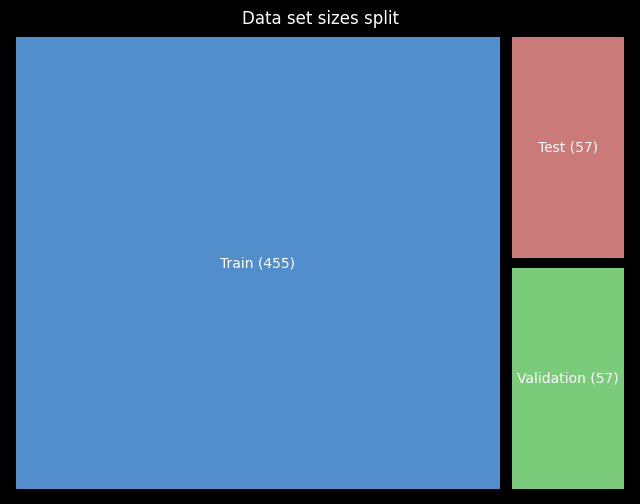

In [10]:
# Random visualizations
sizes = [len(X_train), len(X_val), len(X_test)]
total = sum(sizes)
labels = [f'Train ({len(X_train)})', f'Validation ({len(X_val)})', f'Test ({len(X_test)})']
colors = ['#66b3ff', '#99ff99', '#ff9999']

plt.figure(figsize=(8, 6))
squarify.plot(sizes, label=labels, color=colors, alpha=0.8, pad=True)

plt.title("Data set sizes split")
plt.axis('off') # Turn off axes for better visualization (they're unnecessary for a treemap)
plt.show()

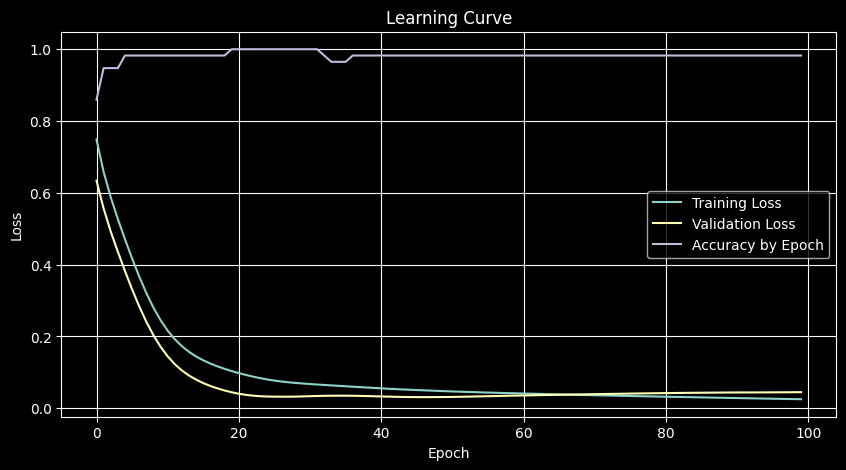

In [11]:
# Learning curve visualization
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(accuracy_score_list, label='Accuracy by Epoch')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()